# Calibrated auROC

John Curtin & Claire Punturieri  
October 23, 2024

# Housekeeping

## Code status

Complete for use in GPS study as of 10/2024.

## Notes

Generates auROC plot.

# Set Up

## Set Up Environment

### Study parameters

In [ ]:
study <- params$study
cv <- params$cv
model <- params$model
algorithms <- params$algorithms
version <- params$version
window <- params$window


### Defaults

In [ ]:

# handle conflicts
options(conflicts.policy = "depends.ok")
devtools::source_url("https://github.com/jjcurtin/lab_support/blob/main/fun_ml.R?raw=true")


ℹ SHA-1 hash of file is "77e91675366f10788c6bcb59fa1cfc9ee0c75281"

### Packages for script

In [ ]:

library(tidyverse)


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Attaching package: 'yardstick'

The following object is masked from 'package:readr':

    spec

ℹ SHA-1 hash of file is "a58e57da996d1b70bb9a5b58241325d6fd78890f"

### Absolute paths

In [ ]:
path_models <- format_path(str_c("studydata/risk/models/", study))


In [ ]:
probs <- read_rds(file.path(path_models, str_c("inner_preds_", 
                                           window, "_", version, "_", 
                                           cv, "_", model, ".rds"))) |>
  #pivot_longer(cols = starts_with("prob"), 
               #names_to = "method", 
               #values_to = ".pred_Lapse") |>
  glimpse()


Rows: 310,797
Columns: 7
$ id_obs          <int> 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456,…
$ outer_split_num <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, …
$ inner_split_num <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, …
$ prob_raw        <dbl> 0.3209265, 0.3209265, 0.3373791, 0.3209265, 0.3209265,…
$ prob_iso        <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, …
$ prob_logi       <dbl> 0.08943453, 0.08943453, 0.07479958, 0.08943453, 0.0894…
$ label           <fct> no lapse, no lapse, no lapse, no lapse, no lapse, no l…

`summarise()` has grouped output by 'sensitivity'. You can override using the
`.groups` argument.

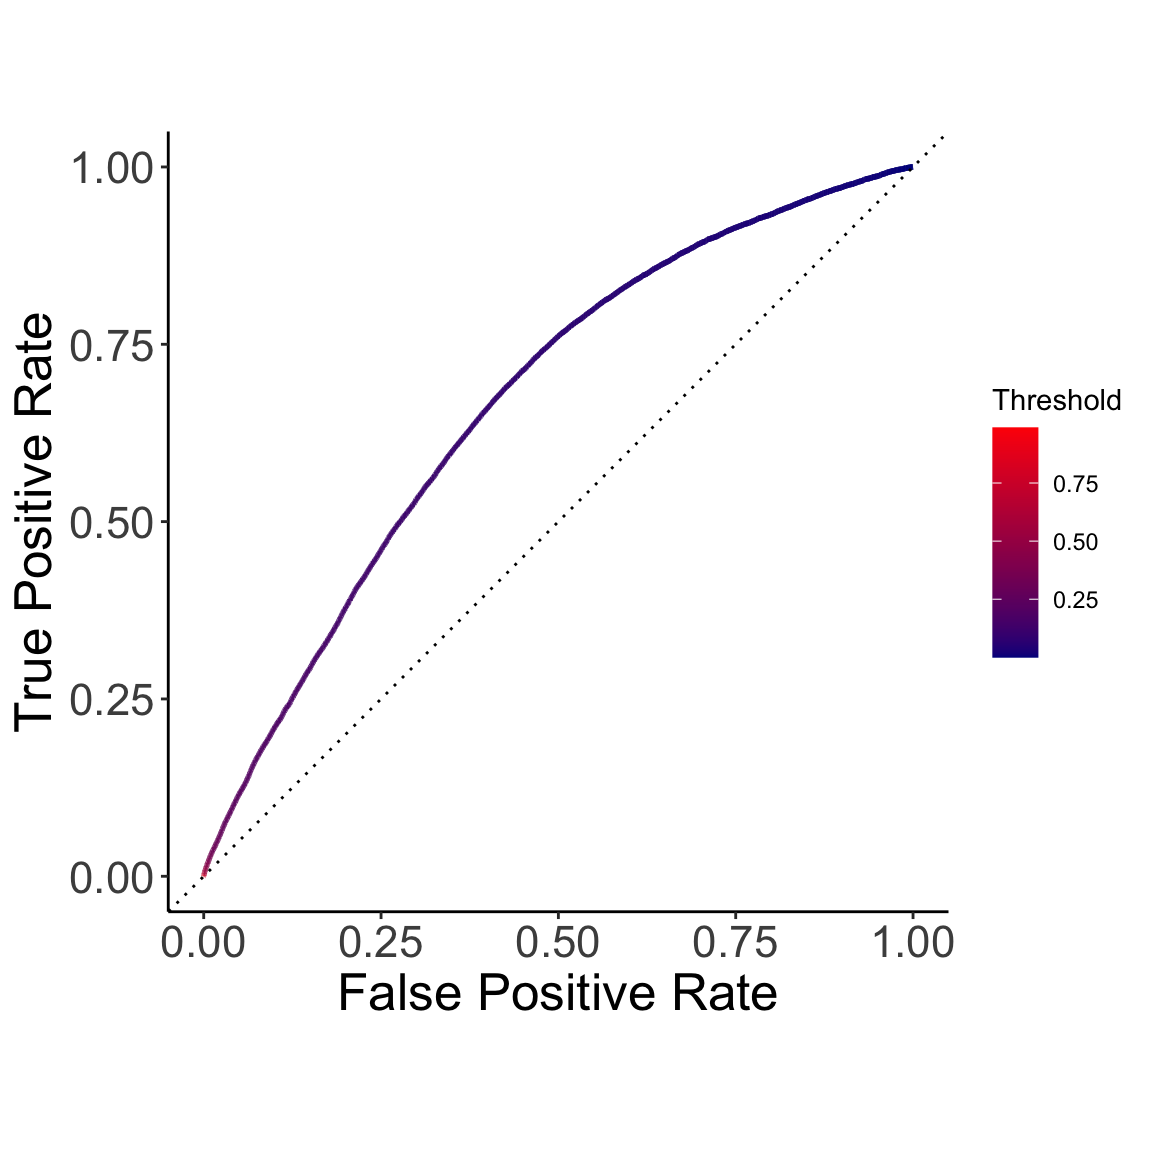

In [ ]:

roc_data <- probs |> 
  roc_curve(prob_logi, truth = label)
  
plot_roc <- function(df, line_colors){
  df |> 
  ggplot(aes(x = 1 - specificity, y = sensitivity, color = model)) +
    geom_path(linewidth = 1.25) +
    geom_abline(lty = 3) +
    coord_fixed(xlim = c(0, 1), ylim = c(0, 1)) +
    labs(x = "False Positive Rate",
        y = "True Positive Rate") +
  scale_color_manual(values = line_colors)
}

roc_data |>
  mutate(sensitivity = round(sensitivity, 4),
         specificity = round(specificity, 4)) |>
  group_by(sensitivity, specificity) |> 
  summarise(.threshold = mean(.threshold)) |> 
  ggplot(aes(x = 1 - specificity, y = sensitivity, color = .threshold)) +
  #ggplot(aes(x = specificity, y = sensitivity, color = .threshold)) +
  geom_path(linewidth = 1) +
  geom_abline(lty = 3) +
  coord_fixed(xlim = c(0, 1), ylim = c(0, 1)) +
  labs(x = "False Positive Rate",
       y = "True Positive Rate") +
  scale_x_continuous(breaks = seq(0,1,.25),
    labels = sprintf("%.2f", seq(0,1,.25))) + # to flip axis
  scale_color_gradient(low="darkblue", high = "red", name = "Threshold") +
  theme(axis.text = element_text(size = rel(1.50)), 
        axis.title = element_text(size = rel(1.75)))


Add in curves for every outer fold.

In [ ]:
# roc_folds <- probs |> 
#   nest(.by = outer_split_num, .key = "preds") |> 
#   mutate(roc = map(preds, \(preds) roc_curve(preds, prob_logi, 
#                                              truth = label)))
# 
# fig_roc_folds <- roc_data |>   # plot region from full concatenated data
#   ggplot(aes(x = 1 - specificity, y = sensitivity)) + 
#   geom_abline(lty = 3) +
#   coord_fixed(xlim = c(0, 1), ylim = c(0, 1)) +
#   labs(x = "Specificity",
#        y = "Sensitivity") +
#   scale_x_continuous(breaks = seq(0,1,.25),
#     labels = sprintf("%.2f", seq(1,0,-.25))) +
#   theme(axis.title.x=element_blank(),
#         axis.text.x=element_blank(),
#         axis.ticks.x=element_blank())
#   
# for (i in 1:nrow(roc_folds)) {
#   fig_roc_folds <- fig_roc_folds +
#      geom_path(data = roc_folds$roc[[i]],
#                mapping = aes(x = 1 - specificity, y = sensitivity),
#                color = "gray")
# }
# 
# roc_data_smooth <- roc_data |> mutate(sensitivity = round(sensitivity, 4),
#                                       specificity = round(specificity, 4)) |>
#   group_by(sensitivity, specificity) |> 
#   summarise(.threshold = mean(.threshold)) 
# 
# #add full concatenated curve
# fig_roc_folds +
#      geom_path(data = roc_data_smooth,
#                mapping = aes(x = 1 - specificity, y = sensitivity, color = .threshold),
#                linewidth = 2) +
#     scale_color_gradient(low="blue", high="red")
